In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Anime faces 
# puts images into colab
# following code must be ran once at the beginning of each new runtime

# Source: https://www.kaggle.com/general/74235
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download splcher/animefacedataset --unzip --force

import shutil
!mkdir anime_faces
shutil.move("/content/images", "/content/anime_faces") 

Saving kaggle.json to kaggle.json
100% 395M/395M [00:18<00:00, 17.8MB/s]
100% 395M/395M [00:18<00:00, 23.0MB/s]


'/content/anime_faces/images'

In [ ]:
# Human faces
# puts images into colab
# following code must be ran once at the beginning of each new runtime

# Source: https://colab.research.google.com/drive/1ytjiIM_sZohV1I6p-9Cov6DtJjidJmcq#scrollTo=BALJJFbe3hNb
import zipfile

!mkdir human_faces && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip 
with zipfile.ZipFile("celeba.zip","r") as zip_ref:
  zip_ref.extractall("human_faces/")

--2023-03-14 16:04:00--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.193.8
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.193.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: ‘celeba.zip’

celeba.zip          100%[===================>]   1.34G  16.0MB/s    in 2m 15s  

2023-03-14 16:06:16 (10.2 MB/s) - ‘celeba.zip’ saved [1443490838/1443490838]



In [ ]:
########## code below is the standard "getting data and splitting into train/validation/testing" code 

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt # for plotting
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

In [ ]:
# Anime Images dataloader
def get_dataloader_anime(batch_size):
  transform = transforms.Compose(
          [transforms.ToTensor(), transforms.Resize([224,224]), 
          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# update directory below to your directory!
  dataset = torchvision.datasets.ImageFolder("./anime_faces",transform=transform)

  # split data into training, validation, testing 
  indices = list(range(len(dataset)))
  np.random.seed(1)
  np.random.shuffle(indices)
  split1 = int(len(indices) * 0.7) # split at 70% 
  split2 = int(len(indices) * 0.2) # split at 20%
  # train:validate:test = 7:2:1

  train_indices, val_indices, test_indices = indices[:split1], indices[split1:split2], indices[split2:]
  train_sampler = SubsetRandomSampler(train_indices)
  val_sampler = SubsetRandomSampler(val_indices)
  test_sampler = SubsetRandomSampler(test_indices)

  training_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                num_workers=2, sampler=train_sampler)
  validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                num_workers=2, sampler=val_sampler)
  testing_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                num_workers=2, sampler=test_sampler)

  return training_loader, validation_loader, testing_loader

In [ ]:
# Human Images dataloader
def get_dataloader_human(batch_size):
  transform = transforms.Compose(
          [transforms.ToTensor(), transforms.Resize([224,224]), 
          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

  # load the dataset 
  dataset = datasets.ImageFolder('./human_faces', transform=transform, target_transform=lambda x:1)

  # split data into training, validation, testing 
  indices = list(range(len(dataset)))
  np.random.seed(1)
  np.random.shuffle(indices)
  split1 = int(len(indices) * 0.7) # split at 70% 
  split2 = int(len(indices) * 0.2) # split at 20%
  # train:validate:test = 7:2:1

  train_indices, val_indices, test_indices = indices[:split1], indices[split1:split2], indices[split2:]
  train_sampler = SubsetRandomSampler(train_indices)
  val_sampler = SubsetRandomSampler(val_indices)
  test_sampler = SubsetRandomSampler(test_indices)

  training_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                num_workers=2, sampler=train_sampler)
  validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                num_workers=2, sampler=val_sampler)
  testing_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                num_workers=2, sampler=test_sampler)

  return training_loader, validation_loader, testing_loader

In [ ]:
def get_dataloader_combined(batch_size):
  transform = transforms.Compose(
          [transforms.ToTensor(), transforms.Resize([224,224]), 
          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

  # load the dataset 
  dataset1 = torchvision.datasets.ImageFolder("./anime_faces",transform=transform)
  dataset2 = datasets.ImageFolder('./human_faces', transform=transform, target_transform=lambda x:1)

  dataset = torch.utils.data.ConcatDataset([dataset1, dataset2])
  # split data into training, validation, testing 
  indices = list(range(len(dataset)))
  np.random.seed(1)
  np.random.shuffle(indices)
  split1 = int(len(indices) * 0.05) # split at 70% 
  split2 = int(len(indices) * 0.075) # split at 20%
  # train:validate:test = 7:2:1

  train_indices, val_indices, test_indices = indices[:split1], indices[split1:split2], indices[split2:]
  train_sampler = SubsetRandomSampler(train_indices)
  val_sampler = SubsetRandomSampler(val_indices)
  test_sampler = SubsetRandomSampler(test_indices)

  training_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                num_workers=2, sampler=train_sampler)
  validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                num_workers=2, sampler=val_sampler)
  testing_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                num_workers=2, sampler=test_sampler)

  return training_loader, validation_loader, testing_loader

In [ ]:
batch_size = 1000
# Anime images dataloader 
training_loader_anime, validation_loader_anime, testing_loader_anime = get_dataloader_anime(batch_size)

# Human images dataloader
training_loader_human, validation_loader_human, testing_loader_human = get_dataloader_human(batch_size)

In [ ]:
def show(img,renorm=False,nrow=8,interpolation='bicubic'):
  if renorm:
    img = img/2 + 0.5
  img_grid = torchvision.utils.make_grid(img,nrow=nrow).numpy()
  plt.figure()
  plt.imshow(np.transpose(img_grid, (1,2,0)), interpolation=interpolation)
  plt.axis('off')
  plt.show()

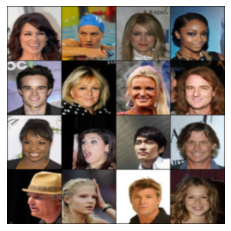

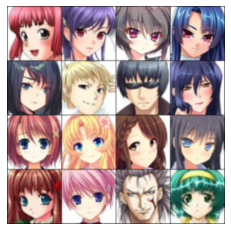

In [ ]:
batch, _ = next(iter(training_loader_human))
show(batch[0:16], renorm = True, nrow=4)

batch, _ = next(iter(training_loader_anime))
show(batch[0:16], renorm = True, nrow=4)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 106 * 106, 32)
        self.fc2 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = x.view(-1, 10 * 106 * 106)
        x = F.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

In [ ]:
def train_discriminator(model, num_epochs=5, learning_rate=0.001, batch_size=64):
    """ Training loop. You should update this."""
    torch.manual_seed(1)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_loader, val_loader, test_loader = get_dataloader_combined(batch_size)


    training_accuracies = np.zeros(num_epochs)
    validation_accuracies = np.zeros(num_epochs)
    losses = []
    for epoch in range(num_epochs):
        for data in train_loader:
            inputs, labels = data
            labels = labels.float()
            inputs = inputs.cuda()
            labels = labels.cuda()
            out = model(inputs).squeeze()
            out = out.cuda()
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        losses.append(float(loss))
        training_accuracies[epoch] = (get_accuracy_discriminator(model, train_loader, batch_size))
        val_accuracy = get_accuracy_discriminator(model, val_loader, batch_size)
        validation_accuracies[epoch] = val_accuracy
        print("Iteration", epoch+1, "Train Loss = ", losses[-1], "Val Accuracy = ", val_accuracy)
    
    plt.plot(range(1, num_epochs+1), training_accuracies, label="Train")
    plt.plot(range(1, num_epochs+1), validation_accuracies, label="Validation")
    plt.show()

def get_accuracy_discriminator(model, loader, batch_size):
  correct = 0
  all = 0
  for data in loader:
    inputs, labels = data
    inputs = inputs.cuda()
    labels = labels.cuda()
    out = model(inputs)
    for unit in range(labels.shape[0]):
      all += 1
      if labels[unit] == 1 and out[unit] >= 0.5:
        correct += 1
      elif labels[unit] == 0 and out[unit] <= 0.5:
        correct += 1
  return correct / all

In [ ]:
d = Discriminator()
d.cuda()
train_discriminator(d, num_epochs=50, batch_size=1000)

Iteration 1 Train Loss =  0.4162740707397461 Val Accuracy =  0.9845205891193267
Iteration 2 Train Loss =  0.4257340431213379 Val Accuracy =  0.9905320108205591
Iteration 3 Train Loss =  0.40656617283821106 Val Accuracy =  0.9956417192666066
Iteration 4 Train Loss =  0.40464717149734497 Val Accuracy =  0.9971445746919146
Iteration 5 Train Loss =  0.4119383692741394 Val Accuracy =  0.9977457168620378
Iteration 6 Train Loss =  0.41271379590034485 Val Accuracy =  0.997595431319507
Iteration 7 Train Loss =  0.41148248314857483 Val Accuracy =  0.9981965734896303
Iteration 8 Train Loss =  0.39960137009620667 Val Accuracy =  0.998497144574692
Iteration 9 Train Loss =  0.4117681682109833 Val Accuracy =  0.998497144574692
Iteration 10 Train Loss =  0.4103201925754547 Val Accuracy =  0.9977457168620378
Iteration 11 Train Loss =  0.40790796279907227 Val Accuracy =  0.9983468590321611
Iteration 12 Train Loss =  0.4093179702758789 Val Accuracy =  0.9983468590321611
Iteration 13 Train Loss =  0.39713

KeyboardInterrupt: ignored

In [ ]:
torch.save(d.state_dict(), "best_model")

In [ ]:
t,v, test = get_dataloader_anime(1)
for x in test:
  ex, lb = x
  ex = ex.cuda()
  ex = ex.float()
  print(d(ex))
  break

tensor([[0.]], device='cuda:0', grad_fn=<SigmoidBackward0>)
